In [1]:
import pandas as pd 
import  matplotlib.pyplot as plt
import numpy as np 
import tensorflow as tf
import keras
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import roc_auc_score , accuracy_score , confusion_matrix , f1_score
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import TfidfVectorizer


In [2]:
train_data  =  pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

In [3]:
test_data  =  pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip')

In [4]:
test_target =  pd.read_csv('../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip')

In [5]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
test_target.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [8]:
len(test_data)

153164

In [9]:
len(train_data)

159571

In [10]:
len(test_target)

153164

In [11]:
train_data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [12]:
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
comments = train_data.drop(['id','comment_text'],axis = 1)
for i in comments.columns :
    print("Percent of {0}s: ".format(i), round(100*comments[i].mean(),2), "%")


Percent of toxics:  9.58 %
Percent of severe_toxics:  1.0 %
Percent of obscenes:  5.29 %
Percent of threats:  0.3 %
Percent of insults:  4.94 %
Percent of identity_hates:  0.88 %


In [14]:
classes = {}
for i in list(comments.columns):
    classes[i] =  comments[i].sum()
n_classes = [classes[i] for i in list(classes.keys())]
classes = list(classes.keys())

<BarContainer object of 6 artists>

<Figure size 864x864 with 0 Axes>

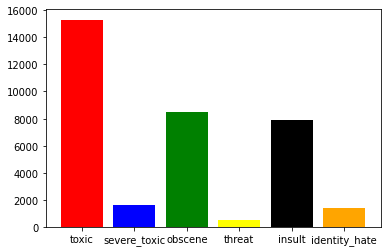

In [15]:
color = ['red','blue','green','yellow','black','orange']
plt.figure(figsize=(12,12))
fig, ax = plt.subplots()
ax.bar(classes,n_classes,color = color)

In [16]:
def  clean_text(text):
    text =  text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    
    return text

In [17]:

train_data.comment_text = train_data.comment_text.apply(clean_text)

In [18]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour i am se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i am really not trying to edit war it ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cannot make any real suggestions on im...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [19]:
nltk.download('stopwords')
sn = SnowballStemmer(language='english')


def stemmer(text):
    words =  text.split()
    train = [sn.stem(word) for word in words if not word in set(stopwords.words('english'))]
    return ' '.join(train)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
train_data.comment_text = train_data.comment_text.apply(stemmer)

In [21]:
train_data.comment_text.head()

0    explan edit made usernam hardcor metallica fan...
1    daww match background colour seem stuck thank ...
2    hey man realli tri edit war guy constant remov...
3    cannot make real suggest improv wonder section...
4                           sir hero chanc rememb page
Name: comment_text, dtype: object

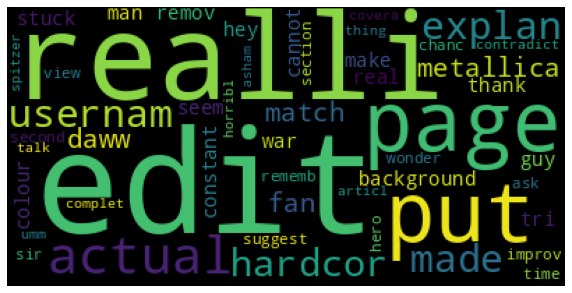

In [22]:
wordcloud = WordCloud(stopwords=stopwords.words('english'),max_words=50).generate(str(train_data.comment_text))
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [23]:
x =  train_data.comment_text
y =  train_data.drop(['id','comment_text'],axis = 1)

In [24]:
x_train,x_test,y_train,y_test =  train_test_split(x,y,test_size = 0.2,random_state = 45)

In [25]:
x_train

9162      anteced etc technic manual page encyclopaedia ...
87716                          redirect talkrepubl survivor
63837     possibl imag hi patrick take look httpbroadsid...
148939    happi new year dheyward classplainlink dheywar...
30008          nobodi said coi remov content clear referenc
                                ...                        
81853                                                messag
143967    attack attack name synchrocat seem respons edi...
60960     ban spot even bother give warn never contribut...
137084    preced unsign comment ad talk contrib june utc...
137630    dear yamla sorri misunderstand dont know els c...
Name: comment_text, Length: 127656, dtype: object

In [26]:
y_train

,toxic,severe_toxic,obscene,threat,insult,identity_hate
9162,0,0,0,0,0,0
87716,0,0,0,0,0,0
63837,0,0,0,0,0,0
148939,0,0,0,0,0,0
30008,0,0,0,0,0,0
...,...,...,...,...,...,...
81853,0,0,0,0,0,0
143967,0,0,0,0,0,0
60960,0,0,0,0,0,0
137084,0,0,0,0,0,0


In [27]:
word_vectorizer = TfidfVectorizer(
    strip_accents='unicode',     
    analyzer='word',            
    token_pattern=r'\w{1,}',    
    ngram_range=(1, 3),         
    stop_words='english',
    sublinear_tf=True)

word_vectorizer.fit(x_train)    
train_word_features = word_vectorizer.transform(x_train)

In [28]:
X_train_transformed = word_vectorizer.transform(x_train)
X_test_transformed = word_vectorizer.transform(x_test)

In [29]:
print(X_train_transformed)

  (0, 4519984)	0.16254979022671487
  (0, 4519982)	0.12851811001523689
  (0, 4502375)	0.04091808252509931
  (0, 4315832)	0.04567361786893691
  (0, 4207682)	0.16254979022671487
  (0, 4207680)	0.1502036843858704
  (0, 4207157)	0.08495431931991004
  (0, 4135267)	0.16254979022671487
  (0, 4135266)	0.16254979022671487
  (0, 4134118)	0.07243925822538433
  (0, 3924582)	0.16254979022671487
  (0, 3924581)	0.16254979022671487
  (0, 3923546)	0.056561284231265184
  (0, 3632377)	0.16254979022671487
  (0, 3632376)	0.16254979022671487
  (0, 3632368)	0.13732911846254384
  (0, 3261139)	0.16254979022671487
  (0, 3261138)	0.16254979022671487
  (0, 3259781)	0.058045660204666755
  (0, 2965651)	0.16254979022671487
  (0, 2965650)	0.16254979022671487
  (0, 2956522)	0.035414984490323126
  (0, 2535228)	0.16254979022671487
  (0, 2535227)	0.15708655136012295
  (0, 2535021)	0.07759130531691433
  :	:
  (127655, 2326865)	0.10949707660587811
  (127655, 2325452)	0.0807368378202353
  (127655, 2245344)	0.1641448879172348

In [30]:
log_reg = LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=45)

classifier = OneVsRestClassifier(log_reg)
classifier.fit(X_train_transformed, y_train)


y_train_pred_proba = classifier.predict_proba(X_train_transformed)
y_test_pred_proba = classifier.predict_proba(X_test_transformed)


roc_auc_score_train = roc_auc_score(y_train, y_train_pred_proba,average='weighted')
roc_auc_score_test = roc_auc_score(y_test, y_test_pred_proba,average='weighted')

print("ROC AUC Score Train:", roc_auc_score_train)
print("ROC AUC Score Test:", roc_auc_score_test)


ROC AUC Score Train: 0.9998057854773116
ROC AUC Score Test: 0.9776951604870202


In [31]:
def make_test_predictions(df,classifier):
    df.comment_text = df.comment_text.apply(clean_text)
    df.comment_text = df.comment_text.apply(stemmer)
    X_test = df.comment_text
    X_test_transformed = word_vectorizer.transform(X_test)
    y_test_pred = classifier.predict_proba(X_test_transformed)
    return y_test_pred
    #y_test_pred_df = pd.DataFrame(y_test_pred,columns=comments.columns) 
    #submission_df = pd.concat([df.id, y_test_pred_df], axis=1)
    #submission_df.to_csv('submission.csv', index = False)
    

In [32]:
xx ={'id':[565],'comment_text':['Shut up your mouth bitch']}
xx = pd.DataFrame(xx)

In [33]:
#test 1 
make_test_predictions(xx,classifier)

array([[0.99999983, 0.87949241, 0.99992886, 0.01799142, 0.9999273 ,
        0.0640647 ]])

In [34]:
xx ={'id':[565],'comment_text':['hi I am happy to be here']}
xx = pd.DataFrame(xx)

In [35]:
#test 2
make_test_predictions(xx,classifier)

array([[0.00573629, 0.00150594, 0.00329071, 0.00081877, 0.00235262,
        0.00235218]])

In [36]:
pickle.dump(classifier, open('classifier.sav', 'wb'))

loaded_model = pickle.load(open('classifier.sav', 'rb'))